In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
cd ~/workspace/theislab/mubind/docs/notebooks/scatac

/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/docs/notebooks/scatac


In [13]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [14]:
atac_path = '../../../annotations/scatac/pancreas_multiome_2022_processed_sample_10000.h5ad'
os.path.exists(atac_path)

True

In [65]:
import scanpy as sc
adata = sc.read_h5ad(atac_path)

In [66]:
adata.shape

(10000, 10000)

In [67]:
n_sample_cells = 350
n_sample_peaks = 350

In [68]:
adata.shape

(10000, 10000)

In [69]:
adata = adata[:,adata.var.modality == 'ATAC'].copy()
obs_sample = pd.Series(adata.obs_names).sample(n_sample_cells)
var_sample = pd.Series(adata.var_names).sample(n_sample_peaks)

adata = adata[adata.obs_names.isin(obs_sample),adata.var_names.isin(var_sample)]

In [70]:
adata.shape

(350, 350)

In [71]:
adata.shape

(350, 350)

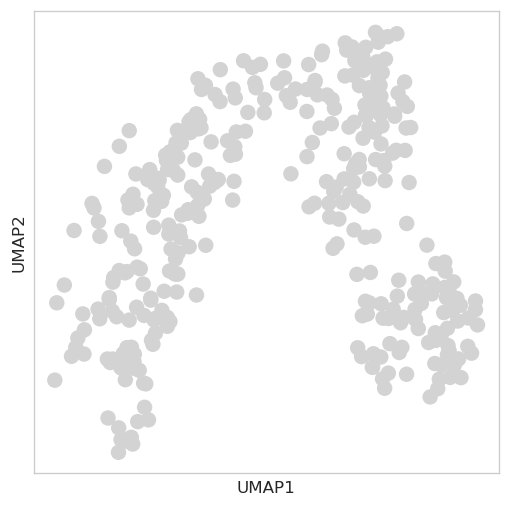

In [72]:
sc.pl.umap(adata)

In [73]:
adata.var

,modality
1-24583368-24584106,ATAC
1-39447972-39448887,ATAC
1-42113222-42114123,ATAC
1-44102011-44102834,ATAC
1-58692063-58693010,ATAC
...,...
X-136107683-136108581,ATAC
X-140769495-140770431,ATAC
X-159944692-159945584,ATAC
X-159954243-159955095,ATAC


In [74]:
adata.var['chr'] = 'chr' + adata.var_names.str.split('-').str[0]
adata.var['start'] = adata.var_names.str.split('-').str[1].astype(int)
adata.var['end'] = adata.var_names.str.split('-').str[2].astype(int)

In [75]:
extend = 50

adata.var['chr'].value_counts()

chr1     29
chr11    29
chr5     26
chr7     26
chr9     26
chr8     21
chr10    19
chr13    19
chr6     16
chr2     16
chr4     16
chr3     15
chr15    15
chr16    15
chr19    14
chr17    13
chr12     9
chr14     9
chrX      9
chr18     8
Name: chr, dtype: int64

In [76]:
adata.var['summit'] = ((adata.var['end'] + adata.var['start']) / 2).astype(int)
adata.var['summit.start'] = adata.var['summit'] - extend
adata.var['summit.end'] = adata.var['summit'] + extend

In [77]:
adata.var['k.summit'] = adata.var['chr'] + ':' + adata.var['summit.start'].astype(str) + '-' + adata.var['summit.end'].astype(str)

In [78]:
adata.shape

(350, 350)

In [79]:
n_seqs = 10000 # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(adata.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='../../../annotations/mm10/genome/mm10.fa')
keys = set([s[0] for s in seqs])
adata = adata[:,adata.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]

/tmp/tmp87uvd0l5
genome mm10 True
../../../annotations/mm10/genome/mm10.fa
True ../../../annotations/mm10/genome/mm10.fa
running bedtools...
bedtools getfasta -fi ../../../annotations/mm10/genome/mm10.fa -bed /tmp/tmp87uvd0l5 -fo /tmp/tmpu61_irdz


In [80]:
len(seqs)

350

In [81]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = adata.X.T

In [82]:
next_data = pd.DataFrame(counts.A) # sparse.from_spmatrix(counts.A)
# next_data = pd.DataFrame.sparse.from_spmatrix(counts)# var = []
# for ri, r in next_data.iterrows():
#     if ri % 1000 == 0:
#         print(ri, next_data.shape)
#     # print(ri, r.values[:-1], r.values[:-1].var())
#     var.append(r.values[:-1].var())
#     # break



In [83]:
next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()

In [84]:
next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
next_data.shape

(350, 351)

In [85]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [86]:
n_cells = 10000
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]

In [87]:
# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)

In [88]:
next_data_sel

,0,1,2,3,4,5,6,7,8,9,...,341,342,343,344,345,346,347,348,349,var
seq,,,,,,,,,,,,,,,,,,,,,
AAGCCCCTGCGGCCAGCGGGCCGTTGAGGTGACGTCAGCAGACGCGCACCGCAAGTTGGAACGCGTGGAGGACGGGGTGGGGCTGTGGGCCAGTCGCGCG,0.0,2.0,0.0,1.0,1.0,2.0,1.0,0.0,2.0,1.0,...,0.0,0.0,1.0,0.0,2.0,0.0,2.0,2.0,1.0,1.448621
ACAGCCCGCGGCTCCCGGGCCTTCTCGCGCCCCAGGCTACTTCCGGCTTCGCCAGCCCGGGCCACGGAGCACGTGACCGAGTGCGGGGCGCGCCTGCGCG,0.0,1.0,2.0,0.0,0.0,2.0,4.0,1.0,0.0,1.0,...,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,1.149611
CATTGTAGCCGCACTGTGCCTCTTGGGGCTTGTAGTCCCGACATCCAACCTGGTGGGCGGAGTCAGGCTGGGACAGCCCGCCGCTTCCGGATGCTCTCCC,1.0,1.0,0.0,1.0,1.0,2.0,5.0,0.0,1.0,1.0,...,0.0,0.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.100254
CCGGTGCTCAGCGAGCCTCAGGTGAGGTTGGCTCCTTCCGGGTAGGCTCGGTTCCGCTTCCCGGAAGCCGCAGAGTCTCTGGGCGTCCTCGGCTCTTCGC,2.0,4.0,1.0,0.0,1.0,1.0,4.0,1.0,2.0,1.0,...,1.0,3.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.095899
CCTCCGCGGAGACCCCCGCCCACTCCACACACTCTCCCATCATGCAGCGGGGAACCGCTGCTGTCCATACGTCACTTCCGGGCGCAGGTGGCTAGGTCGG,1.0,2.0,0.0,1.0,1.0,3.0,1.0,1.0,0.0,2.0,...,0.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,1.0,1.091289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AAGGCTCCAGAGCATTAATGACTGGTTTAAGAGGCAAAAGGAACCGACCAGCGTCGCATCCACCTTTTTATGCCCATCCCAGTGCTTATATTGATTGCTA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002857
TCACCAGAGAGCTGGCAGATTTGGACCAGGAAGCTGAACCACCAAACACAATTCTTTGTGCGGGCCGGATGCCGGCCACGGAAACTGCTGGCTTCTATCA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002857
TCTACCATTGACTGTATAGCCTTCTGGGACTCAGTGAATAGTGGGGAACTTCCTTGTTAACAGAGTTTCTCCTTCTCTGACCTTGTCTGGGATTTTCTAA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [89]:
del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']

In [90]:
df = next_data_sel.copy() # sample
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0
df = df[~zero_counts] # remove zeroes

df.shape

(347, 350)

In [91]:
df2 = df.reset_index().melt('seq').set_index('seq')
# add a baseline count
df2[0] = 1.0
cols = ['batch', 1, 0]
df2.columns = cols
df2 = df2[[0, 1, 'batch']] # cols[::-1]]
df2['batch'] = df2['batch'].astype(int)
print(df2.shape)
print(len(set(df2['batch'])))
n_cells = 200
df2 = df2[df2['batch'].isin(range(0, n_cells))]
print(df2['batch'].value_counts())
df2.head()

(121450, 3)
350
0      347
137    347
127    347
128    347
129    347
      ... 
69     347
70     347
71     347
72     347
199    347
Name: batch, Length: 200, dtype: int64


,0,1,batch
seq,,,
AAGCCCCTGCGGCCAGCGGGCCGTTGAGGTGACGTCAGCAGACGCGCACCGCAAGTTGGAACGCGTGGAGGACGGGGTGGGGCTGTGGGCCAGTCGCGCG,1.0,0.0,0
ACAGCCCGCGGCTCCCGGGCCTTCTCGCGCCCCAGGCTACTTCCGGCTTCGCCAGCCCGGGCCACGGAGCACGTGACCGAGTGCGGGGCGCGCCTGCGCG,1.0,0.0,0
CATTGTAGCCGCACTGTGCCTCTTGGGGCTTGTAGTCCCGACATCCAACCTGGTGGGCGGAGTCAGGCTGGGACAGCCCGCCGCTTCCGGATGCTCTCCC,1.0,1.0,0
CCGGTGCTCAGCGAGCCTCAGGTGAGGTTGGCTCCTTCCGGGTAGGCTCGGTTCCGCTTCCCGGAAGCCGCAGAGTCTCTGGGCGTCCTCGGCTCTTCGC,1.0,2.0,0
CCTCCGCGGAGACCCCCGCCCACTCCACACACTCTCCCATCATGCAGCGGGGAACCGCTGCTGTCCATACGTCACTTCCGGGCGCAGGTGGCTAGGTCGG,1.0,1.0,0


### This is the relatedness graph and used for dynamics filters learning

In [92]:
# sum(adata.obs_names.isin(df.index)

In [93]:
len(seqs)

350

In [94]:
rel = adata[:,~zero_counts].uns['neighbors']['connectivities'].A
# rel[:n_cells,:n_cells].sum()
rel.shape

(350, 350)

In [95]:
rel.shape

(350, 350)

In [96]:
# df2 = []
# for i in df.columns:
#     df3 = df[[i]].copy()
#     df3 = df3.head(100)
#     df3.columns = [0]
#     df3[1] = 1 # need a minimal non-zero count
#     df3['batch'] = i
#     df2.append(df3)
# df2 = pd.concat(df2)
# # df2['is_count_data'] = True
# dataset = mb.datasets.SelexDataset(df2, n_rounds=2, labels=[0, 1], enr_series=False)
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
len(set(dataset.batch))

1

In [97]:
n_batch = len(set(dataset.batch))
n_batch

1

In [98]:
# df = next_data_sel.copy()
# dataset = mb.datasets.GenomicsDataset(df)
# train = tdata.DataLoader(dataset=dataset, batch_size=1000, shuffle=True)

train = tdata.DataLoader(dataset=dataset, batch_size=1024, shuffle=True)


In [99]:
# log_etas = torch.tensor(np.log(df.sum(axis=0) / df.sum().sum())).reshape(1, n_batch).to(device)
# log_etas

In [100]:
b = np.random.randint(0, 2, (3, 4))
conn = np.random.randint(0, 2, (4, 4))

In [101]:
import torch.optim as topti
import warnings
warnings.filterwarnings("ignore")

criterion = mb.tl.PoissonLoss()

n_kernels = 3
model = mb.models.Multibind.make_model(train, n_kernels, criterion, kernels=[0, 2] + [20] * (n_kernels - 2),
                                       # use_dinuc=True, dinuc_mode='full',
                                       optimize_sym_weight=False,
                                       optimize_exp_barrier=True,
                                       optimize_log_dynamic=True,
                                       use_dinuc=False,
                                       device=device,
                                       dinuc_mode=None).cuda()

# Init
def triu_init(m):
    with torch.no_grad():
        m.weight.copy_(torch.triu(m.weight))

# Zero out gradients
def get_zero_grad_hook(mask):
    def hook(grad):
        return grad * mask

    return hook

mask = torch.tril(torch.ones_like(model.selex_module.log_dynamic), -1)
print(mask.device)
print(model.selex_module.log_dynamic)

model.selex_module.log_dynamic.register_hook(get_zero_grad_hook(mask))


# here we set up the relationships between cells using the knn graph, for graph-based learning of activities
model.selex_module.connectivities = torch.tensor(rel).cuda()

cuda:0
Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)


In [102]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [103]:
# %lprun -f model.selex_module.forward model.optimize_iterative(train, n_epochs=[500] + [200] * (n_kernels - 1), show_logo=False, use_mono=True, use_dinuc=False)

In [104]:
model, best_loss = model.optimize_iterative(train, n_epochs=[500] + [200] * (n_kernels - 1), show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                            opt_kernel_shift=[0, 0] + [1] * (n_kernels - 2),
                                            opt_kernel_length=[0, 0] + [1] * (n_kernels - 2),
                                            shift_max=1, shift_step=1, optimiser=topti.Adam,
                                            n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                            kernels = [0] + [2] + [20] * (n_kernels - 2), r2_per_epoch=True,
                                            exp_max=8,
                                            skip_kernels=range(3, 100),
                                            early_stopping=50, log_each=10, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

current kernels

Kernel to optimize 0

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
setting grad status of kernel (mono, dinuc) at 1 to (0, 0)
setting grad status of kernel (mono, dinuc) at 2 to (0, 0)
kernels mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 500 
early_stopping: 50
lr= 0.01, weight_decay= 0, dir weight= 0
Epoch: 11, Loss: 0.569288, R2: 0.23,  best epoch: 9,  secs per epoch: 0.039 s,  secs epoch*1k trials: 0.113s
Epoch: 21, Loss: 0.567227, R2: 0.24,  best epoch: 19,  secs per epoch: 0.033 s,  secs epoch*1k trials: 0.094s
Epoch: 31, Loss: 0.565768, R2: 0.25,  best epoch: 29,  secs per epoch: 0.031 s,  secs epoch*1k trials: 0.088s
Epoch: 41, Loss: 0.564743, R2: 0.25,  best epoch: 39,  secs per epoch: 0.029 s,  secs epoch*1k trials: 0.085s
Epoch: 51, Loss: 0.564019, R2: 0.26,  best epoch: 49,  secs per epoch: 0.029 s,  secs epoch*1k trials: 0.083s
Epoch: 61, Loss: 0.563507, R2: 0.26,  best epoch: 59, 

In [105]:
n_cols = len(model.binding_modes)

True
1


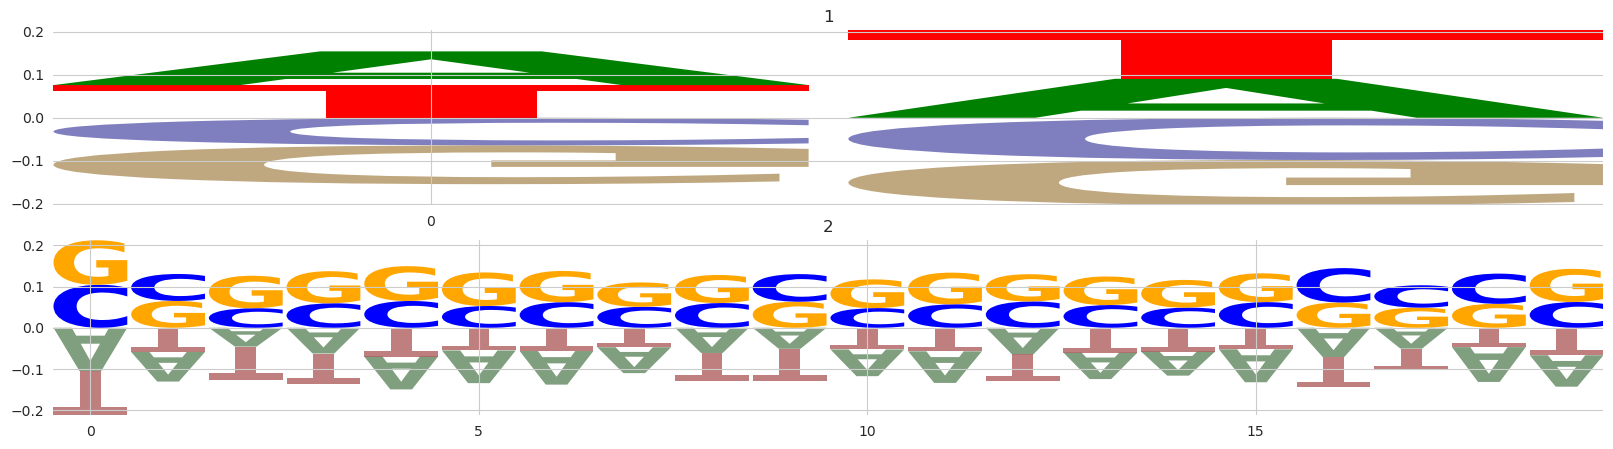

In [106]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 5
rcParams['figure.dpi'] = 100
mb.pl.conv(model, n_cols=int(n_cols / 2), n_rows=2, show=True)
plt.show()


In [107]:
log_dynamic = model.selex_module.log_dynamic
log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
# triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
log_dynamic

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<AddBackward0>)

In [108]:
log_dynamic.max()

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)

<AxesSubplot: >

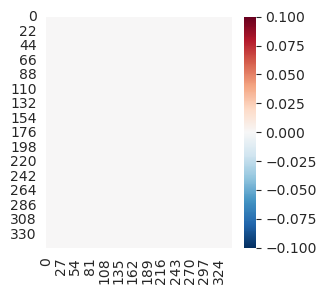

In [109]:
import seaborn as sns
mb.pl.set_rcParams({'figure.figsize': [3, 3]})
sns.heatmap(log_dynamic.detach().cpu(), cmap='RdBu_r')

<AxesSubplot: xlabel='index', ylabel='r2'>

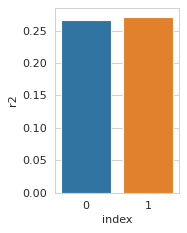

In [110]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 2, 3
rcParams['figure.dpi'] = 80
import seaborn as sns
r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
sns.barplot(data=r2, x='index', y='r2')

In [111]:
log_dynamic = model.selex_module.log_dynamic
log_dynamic.sum()

tensor(0., device='cuda:0', grad_fn=<SumBackward0>)

In [112]:
torch.set_printoptions(precision=2)
log_dynamic = log_dynamic.detach().cpu().numpy()

n_rounds = model.selex_module.n_rounds
triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
log_dynamic[triu_indices[0], triu_indices[1]] = 0
dynamic_score = log_dynamic.sum(axis=0)


In [113]:

# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
adata.obs['dynamic_score'] = dynamic_score

StopIteration: 

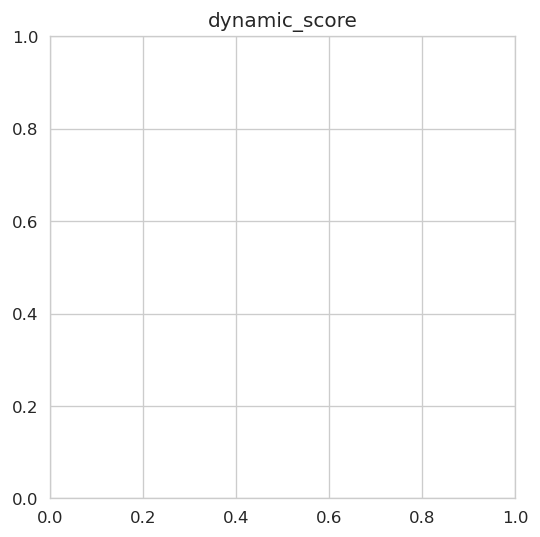

In [114]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 120
sc.pl.umap(adata, color='dynamic_score', cmap='RdBu_r', sort_order=True)


In [ ]:
mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=8)

In [ ]:
import resource
print('total GB used:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)
